# Load the data

In [1]:
import numpy as np
import pandas as pd

#load the data
data_pd=pd.read_csv('sentiment (Shrivastava on kaggle, Public Domain).csv',encoding ="ISO 8859 1")

#print a few examples of the data
print(data_pd.head())

#move from data frame to numpy array
data_np=data_pd.to_numpy()


   polarity of tweet   id of the tweet             date of the tweet  \
0                   0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
1                   0       1467810917  Mon Apr 06 22:19:53 PDT 2009   
2                   0       1467811184  Mon Apr 06 22:19:57 PDT 2009   
3                   0       1467811193  Mon Apr 06 22:19:57 PDT 2009   
4                   0       1467811372  Mon Apr 06 22:20:00 PDT 2009   

      query           user                                 text of the tweet   
0  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  
1  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...  
2  NO_QUERY        ElleCTF    my whole body feels itchy and like its on fire   
3  NO_QUERY         Karoli  @nationwideclass no, it's not behaving at all....  
4  NO_QUERY       joy_wolf                      @Kwesidei not the whole crew   


# Labels preprocessing

In [2]:
#get the labels
labels=data_np[:,0]

#check the labels
print(f'unique label values:{np.unique(labels)}') 

#make label values 0 and 1 
labels=data_np[:,0]/4  

#make as array of floats
labels=np.asarray(labels).astype('float32') 

#check if the labels are balanced
no_neg_labels=len(labels[labels==0]) 
no_pos_labels=len(labels[labels==1]) 
print(f'number of negative labels: {no_neg_labels}\n number of positive labels: {no_pos_labels}')

#create weights to balance the labels (will be used when training the model)
class_weight = {0: 1, 1: no_neg_labels/no_pos_labels}

unique label values:[0 4]
number of negative labels: 799996
 number of positive labels: 248576


# Features preprocessing

In [3]:
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

#get the tweets (features)
tweets=data_np[:,5]

#1)tokenize the tweets (separate into single words and give each word numerical value)

#1.1)#train/test split for tokenizing (tokenizer is fitted only on train data)
tweets_train,_,_,_=train_test_split(tweets,labels,test_size=0.2,random_state=0)

#1.2)fit tokenizer on the train data 
num_words = 10000      #limit the tweets' number of words to the 10k most frequent (to avoid overfitting)
tokenizer=keras.preprocessing.text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(tweets_train)

#1.3)apply tokenizer on all tweets (train and test)
tk_tweets=tokenizer.texts_to_sequences(tweets)  



#2)padding all tweets-make tokenized tweets with equal lengthes (by zero padding).
#padding with all tweets makes the test and train have equal lengthes after padding (but a 2nd train/test split is required)
pad_tk_tweets=tf.keras.utils.pad_sequences(tk_tweets) 

#make as array of floats
pad_tk_tweets=np.asarray(pad_tk_tweets).astype('float32') 



#3)train/test split for model trainning
x_train,x_test,y_train,y_test=train_test_split(pad_tk_tweets,labels,test_size=0.2)

# Preparation for the embedding layer of the model

In [4]:
#get the number of words in the tweets
vocab_size = num_words+1  #+1 for the zero value that is added by zero padding

#get the size of the padded tokenized tweets
pad_len=len(pad_tk_tweets[0])

#choose the embedding dimension
emb_dim=10

# Create the model

In [5]:
model= keras.models.Sequential()
model.add(keras.layers.Embedding(vocab_size, emb_dim, input_length=pad_len, mask_zero=True)) #input_length is reauired if dense layers follow
model.add(keras.layers.LSTM(50, dropout=0.2 ,recurrent_dropout=0.2, return_sequences=True)) #dropout to tackle overfitting
model.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(keras.layers.Dense(50, activation ='relu'))
model.add(keras.layers.Dense(1, activation ='sigmoid')) #output layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 10)            100010    
                                                                 
 lstm (LSTM)                 (None, 40, 50)            12200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 135,011
Trainable params: 135,011
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [6]:
#Next line to train the model (muted since training was already done and the results were saved)
#history=model.fit(x_train , y_train , epochs =5, batch_size=300, class_weight=class_weight, validation_data=(x_test,y_test))


#load saved model
import pickle
saved_model=tf.keras.models.load_model('model4')
with open('model4/trainHistoryDict', "rb") as file_pi:
    saved_history = pickle.load(file_pi)

# Plot "accuracy" from train and test data

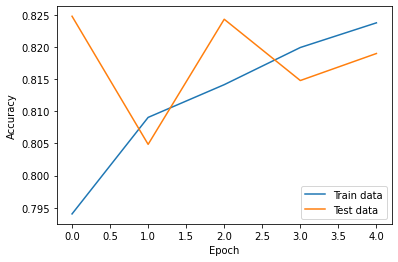

Accuracy train: 0.8237375617027283
Accuracy validiation: 0.8189685940742493


In [8]:
import matplotlib.pyplot as plt

#Plot using the "saved_history" from the saved results of training 

plt.plot(saved_history['accuracy'], label='Train data')
plt.plot(saved_history['val_accuracy'], label='Test data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Print R2 values at the end of training
print(f"Accuracy train: {saved_history['accuracy'][-1]}")
print(f"Accuracy validiation: {saved_history['val_accuracy'][-1]}")


# Evaluation of the model (confusion matrix)

6554/6554 [==============================] - 85s 13ms/step


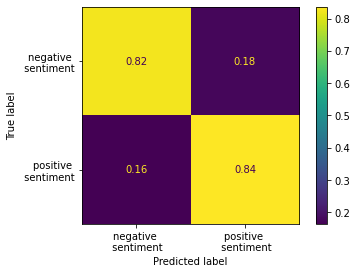

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#plot confusion matrix
y_pred=np.round(saved_model.predict(x_test),0).flatten()
y_true=y_test
con_mat=confusion_matrix(y_true, y_pred, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat,display_labels=['negative \n sentiment','positive \n sentiment']) #
disp.plot()
plt.show()


#Remark: equal proportions are seen for true negatives and true positives, althought the labels are not balanced, due to 
# the use of "class_weight"

# Evaluation of the model (with "unseen" tweets)

In [27]:
my_tweet1=['i feel good today'] 
my_tweet2=['some days i feel like, i do not want to get out of bed'] 
my_tweet3=['it is not black and white'] 


#function that uses the model to output a tweet's sentiment
def get_sentiment(tweet):
    #Tokanize and pad the tweet
    pad_tk_tweet=np.asarray(tf.keras.utils.pad_sequences(tokenizer.texts_to_sequences(tweet),maxlen=pad_len)).astype('float32')
    
    if np.round(saved_model.predict(pad_tk_tweet),0).flatten()==0:
        sentiment='negative sentiment'
    else:
        sentiment='positive sentiment'
    
    return sentiment
        
print(f'{my_tweet1} has a {get_sentiment(my_tweet1)}')
print(f'{my_tweet2} has a {get_sentiment(my_tweet2)}')
print(f'{my_tweet3} has a {get_sentiment(my_tweet3)}')
        

1/1 [==============================] - 0s 30ms/step
['i feel good today'] has a positive sentiment
1/1 [==============================] - 0s 22ms/step
['some days i feel like, i do not want to get out of bed'] has a negative sentiment
1/1 [==============================] - 0s 42ms/step
['it is not black and white'] has a negative sentiment
